In [1]:
import tensorflow as tf
import math
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix


2025-11-09 09:45:58.467618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762681558.641431      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762681558.690608      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
assert tf.config.list_physical_devices('GPU'), "No GPU detected: Check your Kaggle environment settings."


Num GPUs Available: 1


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DROPOUT_RATE = 0.3
INITIAL_LR = 0.001
EPOCHS = 100
SEED = 42

train_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/train'
val_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/val'
test_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/test'

EXPERIMENT_NAME = "densenet_bam"  # Options: "densenet_eca", "densenet_ca", "densenet_both"
ATTENTION_TYPE = "bam"  # Options: cbam, simam, gam, triplet, shuffle, bam


In [4]:
datagen_args = dict(rescale=1./255)
train_gen = ImageDataGenerator(**datagen_args)
val_gen = ImageDataGenerator(**datagen_args)
test_gen = ImageDataGenerator(**datagen_args)
train_flow = train_gen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=SEED)
val_flow = val_gen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_flow = test_gen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
num_classes = train_flow.num_classes


Found 14219 images belonging to 43 classes.
Found 11955 images belonging to 43 classes.
Found 11958 images belonging to 43 classes.


In [5]:
# ============================================================================
# BAM (Bottleneck Attention Module) - BMVC 2018
# Parallel Channel + Spatial: Lighter than CBAM
# Paper: "BAM: Bottleneck Attention Module"
# ============================================================================
class BAM(layers.Layer):
    """
    BAM: Bottleneck Attention Module
    Parallel channel and spatial attention (unlike CBAM's sequential)

    Args:
        reduction: channel reduction ratio (default: 16)
        dilation: dilation rate for spatial branch (default: 4)
    """
    def __init__(self, reduction=16, dilation=4, **kwargs):
        super(BAM, self).__init__(**kwargs)
        self.reduction = reduction
        self.dilation = dilation

    def build(self, input_shape):
        channels = input_shape[-1]

        # Channel attention branch
        self.gap = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(channels // self.reduction, activation='relu')
        self.fc2 = layers.Dense(channels)

        # Spatial attention branch
        self.conv1 = layers.Conv2D(
            channels // self.reduction,
            kernel_size=1,
            activation='relu'
        )
        self.conv2 = layers.Conv2D(
            channels // self.reduction,
            kernel_size=3,
            padding='same',
            dilation_rate=self.dilation,
            activation='relu'
        )
        self.conv3 = layers.Conv2D(
            channels // self.reduction,
            kernel_size=3,
            padding='same',
            dilation_rate=self.dilation,
            activation='relu'
        )
        self.conv4 = layers.Conv2D(1, kernel_size=1)

        super(BAM, self).build(input_shape)

    def call(self, inputs):
        # Channel attention
        channel_att = self.gap(inputs)
        channel_att = self.fc2(self.fc1(channel_att))
        channel_att = tf.expand_dims(tf.expand_dims(channel_att, 1), 1)

        # Spatial attention
        spatial_att = self.conv1(inputs)
        spatial_att = self.conv2(spatial_att)
        spatial_att = self.conv3(spatial_att)
        spatial_att = self.conv4(spatial_att)

        # Combine (parallel, not sequential)
        attention = tf.nn.sigmoid(channel_att + spatial_att)
        output = inputs + (inputs * attention)

        return output

    def get_config(self):
        config = super(BAM, self).get_config()
        config.update({
            "reduction": self.reduction,
            "dilation": self.dilation
        })
        return config



def build_densenet_with_attention(
    num_classes,
    img_size=(224, 224),
    attention_name='cbam',
    dropout_rate=0.3
):
    """
    Build DenseNet121 with modern attention mechanisms

    Architecture: Input -> DenseNet121 -> ATTENTION -> Dense Layers

    Args:
        num_classes: number of output classes
        img_size: input image size
        attention_name: which attention to use
        dropout_rate: dropout rate for dense layers

    Returns:
        Keras Model
    """
    from tensorflow.keras.applications import DenseNet121
    from tensorflow.keras import Model

    # Load DenseNet121 backbone
    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=img_size + (3,)
    )

    x = base_model.output

    # Add Attention Module
    attention_map = {
        # 'cbam': CBAM,
        # 'simam': SimAM,
        # 'gam': GAM,
        # 'triplet': TripletAttention,
        # 'shuffle': ShuffleAttention,
        'bam': BAM
    }

    if attention_name.lower() in attention_map:
        AttentionLayer = attention_map[attention_name.lower()]
        x = AttentionLayer(name=f'{attention_name}_attention')(x)
        print(f"✓ Added {attention_name.upper()} attention after DenseNet121")
    else:
        print(f"⚠ Unknown attention: {attention_name}. Proceeding without attention.")

    # Classification Head (matching your original architecture)
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dropout(dropout_rate, name='dropout_1')(x)

    x = layers.Dense(1024, activation='relu', name='fc1')(x)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Dropout(dropout_rate, name='dropout_2')(x)

    x = layers.Dense(512, activation='relu', name='fc2')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Dropout(dropout_rate, name='dropout_3')(x)

    x = layers.Dense(256, activation='relu', name='fc3')(x)
    x = layers.BatchNormalization(name='bn3')(x)
    x = layers.Dropout(dropout_rate, name='dropout_4')(x)

    x = layers.Dense(128, activation='relu', name='fc4')(x)

    output = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(
        inputs=base_model.input,
        outputs=output,
        name=f'DenseNet121_{attention_name}'
    )

    return model




In [6]:
print(f"\n{'='*70}")
print(f"Building DenseNet121 with {ATTENTION_TYPE.upper()} attention")
print(f"{'='*70}\n")

model = build_densenet_with_attention(
    num_classes=num_classes,
    img_size=IMG_SIZE,
    attention_name=ATTENTION_TYPE,
    dropout_rate=DROPOUT_RATE
)

# Make entire model trainable (same as your setup)
model.trainable = True

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=INITIAL_LR,
    weight_decay=0.01
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



Building DenseNet121 with BAM attention



I0000 00:00:1762681577.822744      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✓ Added BAM attention after DenseNet121


In [7]:
print("\nModel Summary:")
print(f"Total parameters: {model.count_params():,}")
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")
print(f"Parameter increase vs baseline: +{model.count_params() - 8788843:,}")



Model Summary:
Total parameters: 9,060,524
Trainable parameters: 8,973,292
Parameter increase vs baseline: +271,681


In [8]:
checkpoint_cb = ModelCheckpoint(
    "best_densenet_model.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr]

print(f"\n{'='*70}")
print("Starting training...")
print(f"{'='*70}\n")

history = model.fit(
    train_flow,
    epochs=EPOCHS,
    validation_data=val_flow,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

# Save history
with open(f'{EXPERIMENT_NAME}_history.json', 'w') as f:
    json.dump(history.history, f)



Starting training...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1762681678.211457     127 service.cc:148] XLA service 0x796c0c33a4d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762681678.212322     127 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762681687.769490     127 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762681773.571331     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.1137 - loss: 3.3193
Epoch 1: val_accuracy improved from -inf to 0.24433, saving model to best_densenet_model.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 476s 640ms/step - accuracy: 0.1139 - loss: 3.3179 - val_accuracy: 0.2443 - val_loss: 2.3429 - learning_rate: 0.0010
Epoch 2/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.4004 - loss: 1.7327
Epoch 2: val_accuracy did not improve from 0.24433
445/445 ━━━━━━━━━━━━━━━━━━━━ 114s 255ms/step - accuracy: 0.4005 - loss: 1.7325 - val_accuracy: 0.2320 - val_loss: 2.7794 - learning_rate: 0.0010
Epoch 3/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.5462 - loss: 1.2609
Epoch 3: val_accuracy improved from 0.24433 to 0.46441, saving model to best_densenet_model.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 117s 263ms/step - accuracy: 0.5462 - loss: 1.2608 - val_accuracy: 0.4644 - val_loss: 1.4971 - learning_rate: 0.0010
Epoch 4/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.650

In [9]:
print("\nEvaluating on test set...")

test_flow.reset()
y_true = test_flow.classes
y_pred_probs = model.predict(test_flow, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

target_names = list(test_flow.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names, digits=4, output_dict=True)
cm = confusion_matrix(y_true, y_pred)
test_loss, test_acc = model.evaluate(test_flow, verbose=0)

# Metrics
precision = report["macro avg"]["precision"]
recall = report["macro avg"]["recall"]
f1 = report["macro avg"]["f1-score"]
num_params = model.count_params()


print(f"\n{'='*70}")
print("FINAL RESULTS")
print(f"{'='*70}")
print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Attention Type: {ATTENTION_TYPE.upper()}")
print(f"{'-'*70}")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1 Score:       {f1:.4f}")
print(f"Parameters:     {num_params:,}")
print(f"Param increase: +{num_params - 8788843:,}")
print(f"{'='*70}\n")

# Compare with baseline
baseline_acc = 0.9489
baseline_f1 = 0.9235
print("COMPARISON WITH BASELINE:")
print(f"Accuracy improvement: {(test_acc - baseline_acc)*100:+.2f}%")
print(f"F1 improvement:       {(f1 - baseline_f1)*100:+.2f}%")



Evaluating on test set...
374/374 ━━━━━━━━━━━━━━━━━━━━ 145s 359ms/step

FINAL RESULTS
Experiment: densenet_bam
Attention Type: BAM
----------------------------------------------------------------------
Test Loss:      0.1917
Test Accuracy:  0.9475
Precision:      0.9278
Recall:         0.9302
F1 Score:       0.9259
Parameters:     9,060,524
Param increase: +271,681

COMPARISON WITH BASELINE:
Accuracy improvement: -0.14%
F1 improvement:       +0.24%


In [10]:
results = {
    "Model": [EXPERIMENT_NAME],
    "Attention": [ATTENTION_TYPE],
    "Params": [num_params],
    "Param_increase": [num_params - 8788843],
    "Test_Loss": [f"{test_loss:.4f}"],
    "Test_Acc": [f"{test_acc:.4f}"],
    "Precision": [f"{precision:.4f}"],
    "Recall": [f"{recall:.4f}"],
    "F1": [f"{f1:.4f}"],
    "Acc_vs_baseline": [f"{(test_acc - baseline_acc)*100:+.2f}%"],
    "F1_vs_baseline": [f"{(f1 - baseline_f1)*100:+.2f}%"]
}

import pandas as pd
df = pd.DataFrame(results)
print("\n" + df.to_markdown(index=False))

# Save to CSV for easy comparison
df.to_csv(f'{EXPERIMENT_NAME}_results.csv', index=False)

# Save model
model.save(f'{EXPERIMENT_NAME}_final_model.keras')
model.save_weights(f'{EXPERIMENT_NAME}_final.weights.h5')



| Model        | Attention   |   Params |   Param_increase |   Test_Loss |   Test_Acc |   Precision |   Recall |     F1 | Acc_vs_baseline   | F1_vs_baseline   |
|:-------------|:------------|---------:|-----------------:|------------:|-----------:|------------:|---------:|-------:|:------------------|:-----------------|
| densenet_bam | bam         |  9060524 |           271681 |      0.1917 |     0.9475 |      0.9278 |   0.9302 | 0.9259 | -0.14%            | +0.24%           |


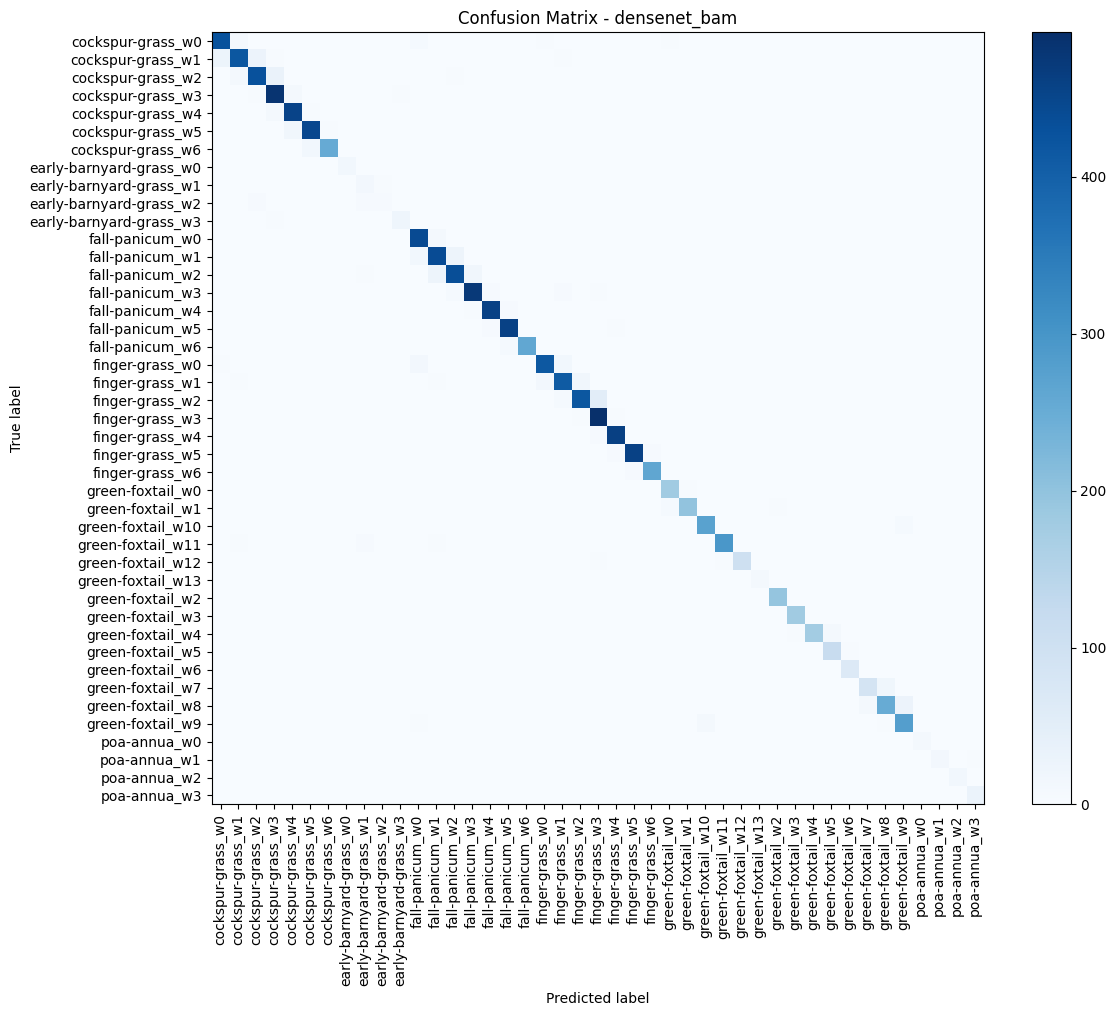

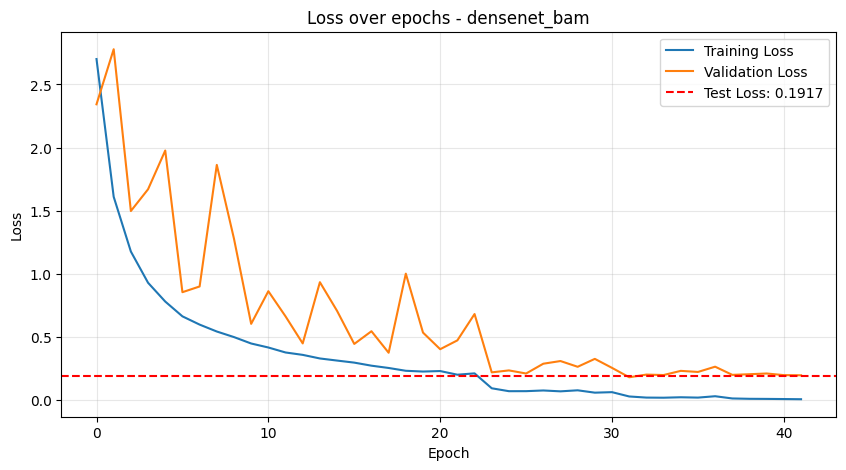

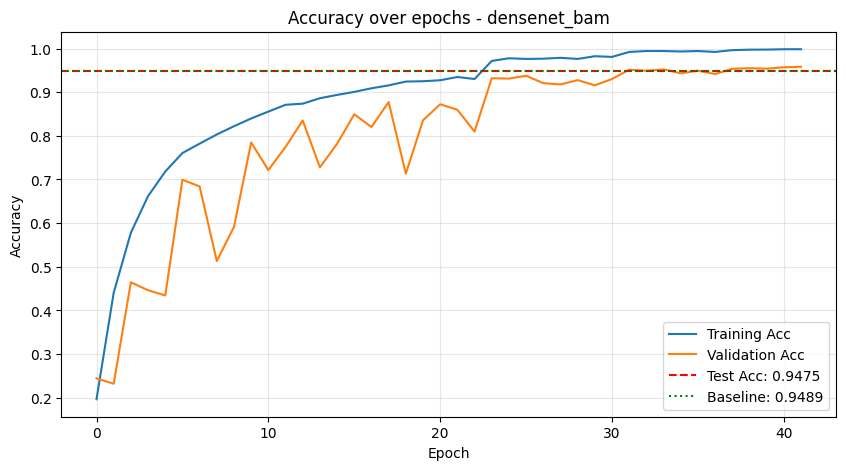


All results saved with prefix: densenet_bam_
Training complete! 🎉


In [11]:
# Confusion Matrix
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - {EXPERIMENT_NAME}")
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=90)
plt.yticks(tick_marks, target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(f'{EXPERIMENT_NAME}_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Loss curves
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.legend()
plt.title(f"Loss over epochs - {EXPERIMENT_NAME}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.savefig(f'{EXPERIMENT_NAME}_loss.png', dpi=150, bbox_inches='tight')
plt.show()

# Accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Training Acc")
plt.plot(history.history["val_accuracy"], label="Validation Acc")
plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Acc: {test_acc:.4f}')
plt.axhline(y=baseline_acc, color='g', linestyle=':', label=f'Baseline: {baseline_acc:.4f}')
plt.legend()
plt.title(f"Accuracy over epochs - {EXPERIMENT_NAME}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.savefig(f'{EXPERIMENT_NAME}_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nAll results saved with prefix: {EXPERIMENT_NAME}_")
print("Training complete! 🎉")


In [12]:
!zip -r bam.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/best_densenet_model.h5 (deflated 14%)
  adding: kaggle/working/densenet_bam_history.json (deflated 61%)
  adding: kaggle/working/densenet_bam_final.weights.h5 (deflated 14%)
  adding: kaggle/working/densenet_bam_final_model.keras (deflated 14%)
  adding: kaggle/working/densenet_bam_confusion_matrix.png (deflated 24%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/densenet_bam_loss.png (deflated 8%)
  adding: kaggle/working/densenet_bam_accuracy.png (deflated 8%)
  adding: kaggle/working/densenet_bam_results.csv (deflated 26%)
